In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!unzip /content/gdrive/MyDrive/GAN_datasets/face_scrub.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38692_18105.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38693_18106.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38695_18108.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38699_18111.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38702_18113.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38704_18115.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38716_18119.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38728_18126.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38730_18127.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38748_18138.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38751_18140.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38753_18142.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38755_18143.jpeg  


In [5]:
!unzip /content/gdrive/MyDrive/GAN_datasets/anime.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /images/62764_2019.jpg  
  inflating: /images/62765_2019.jpg  
  inflating: /images/62766_2019.jpg  
  inflating: /images/62767_2019.jpg  
  inflating: /images/62768_2019.jpg  
  inflating: /images/62769_2019.jpg  
  inflating: /images/6276_2003.jpg   
  inflating: /images/62770_2019.jpg  
  inflating: /images/62771_2019.jpg  
  inflating: /images/62772_2019.jpg  
  inflating: /images/62773_2019.jpg  
  inflating: /images/62774_2019.jpg  
  inflating: /images/62775_2019.jpg  
  inflating: /images/62776_2019.jpg  
  inflating: /images/62777_2019.jpg  
  inflating: /images/62778_2019.jpg  
  inflating: /images/62779_2019.jpg  
  inflating: /images/6277_2003.jpg   
  inflating: /images/62780_2019.jpg  
  inflating: /images/62781_2019.jpg  
  inflating: /images/62782_2019.jpg  
  inflating: /images/62783_2019.jpg  
  inflating: /images/62784_2019.jpg  
  inflating: /images/62785_2019.jpg  
  inflating: /images/62786_2019.jpg  

In [4]:
import glob
faces = glob.glob('/*_faces/*/*.jpeg')
animes = glob.glob("/images/*.jpg")

In [5]:
len(faces), len(animes)

(42196, 63565)

In [6]:
import cv2
for file in animes[:10]:
    img = cv2.imread(file)
    print (img.shape)

(112, 112, 3)
(99, 99, 3)
(118, 118, 3)
(75, 75, 3)
(88, 88, 3)
(58, 58, 3)
(97, 97, 3)
(90, 90, 3)
(87, 87, 3)
(82, 82, 3)


Human Faces


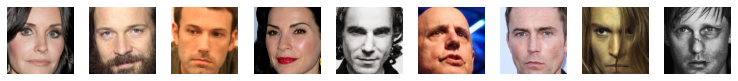

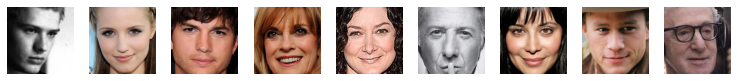

--------------------------------------------------------------------------------
Anime Faces


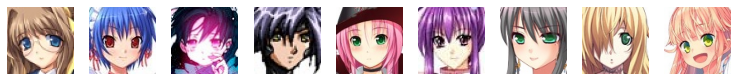

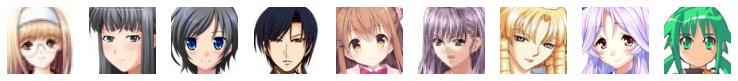

In [7]:
print ("Human Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Anime Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(animes)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [8]:
import tensorflow_addons as tfa

In [9]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [10]:
def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, translated_image

source_image, translated_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [11]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [12]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_11 (I (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       5245

In [13]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# CARTOON-GAN

In [14]:
source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))

# Domain Transfer
fake_anime = generator_network(source_image)
  
discriminator_network.trainable=False

# Tell Real vs Fake
real_vs_fake = discriminator_network(fake_anime)

cartoon_gan = tensorflow.keras.models.Model(inputs = source_image, outputs = [real_vs_fake, fake_anime])
cartoon_gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       41833475  
_________________________________________________________________
model_1 (Functional)         (None, 8, 8, 1)           2766529   
Total params: 44,600,004
Trainable params: 41,833,475
Non-trainable params: 2,766,529
_________________________________________________________________


# VGG features

In [34]:
image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

pre_trained_vgg = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
pre_trained_vgg_model = tensorflow.keras.models.Model(inputs=pre_trained_vgg.input, outputs=pre_trained_vgg.get_layer('block4_conv4').output)

pre_trained_image_feautures = pre_trained_vgg_model(image_input)

custom_vgg = tensorflow.keras.models.Model(inputs=image_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_9 (Functional)         (None, 16, 16, 512)       10585152  
Total params: 10,585,152
Trainable params: 10,585,152
Non-trainable params: 0
_________________________________________________________________
None


# Custom GAN Loss (vgg content Loss)

In [35]:
def custom_gan_loss(y_true, y_pred):
    custom_vgg.trainable=False
    y_true_features = custom_vgg(y_true)
    y_pred_features = custom_vgg(y_pred)
    content_loss = tensorflow.compat.v1.losses.absolute_difference(y_true_features, y_pred_features)
    return content_loss

# Compiling Models

In [36]:
cartoon_gan.compile(loss=['binary_crossentropy', custom_gan_loss], optimizer=adam_optimizer, loss_weights=[1, 1])

# Define Data Generators

In [37]:
def faces_to_animes(faces, generator_network):
    generated_samples = generator_network.predict_on_batch(faces)
    return generated_samples

def do_smoothing(img):
    # taken from https://github.com/penny4860/Keras-CartoonGan/blob/master/cartoon/utils.py
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)

    rgb_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pad_img = np.pad(rgb_img, ((2,2), (2,2), (0,0)), mode='reflect')
    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)

    gauss_img = np.copy(rgb_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))

    return gauss_img

def get_training_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    face_images = np.array(images)

    random_files = np.random.choice(animes, size=batch_size)
    images = []
    smooth_images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        smooth = do_smoothing(img)
        images.append((img-127.5)/127.5)
        smooth_images.append((smooth-127.5)/127.5)
    anime_images = np.array(images)
    anime_smooth_images = np.array(smooth_images)
    return face_images, anime_images, anime_smooth_images

def show_generator_results(generator_network):
    images = []
    for j in range(7):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

    print ('Human Face Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Anime Version')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = faces_to_animes(np.array([img]), generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

## Check smooth version

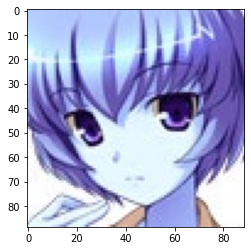

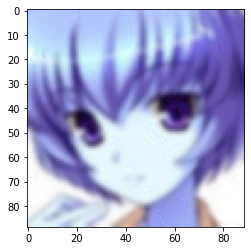

In [38]:
img = cv2.imread(animes[25])
plt.imshow(img)
plt.show()
plt.imshow(do_smoothing(img))
plt.show()

# Training GAN

In [39]:
len(faces), len(animes)

(42196, 63565)

Human Face Images


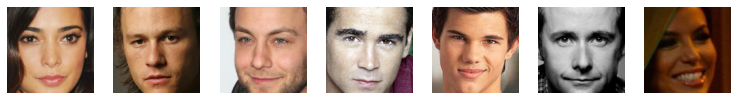

Anime Version


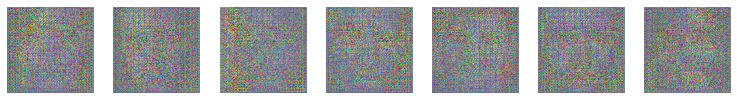

Epoch:0, Step:0, D-Loss:2.071, D-Acc:53.516, G-Loss:9.371
Epoch:0, Step:100, D-Loss:0.271, D-Acc:58.984, G-Loss:7.156
Epoch:0, Step:200, D-Loss:0.215, D-Acc:63.542, G-Loss:9.881
Epoch:0, Step:300, D-Loss:0.277, D-Acc:67.839, G-Loss:8.819
Epoch:0, Step:400, D-Loss:0.210, D-Acc:63.802, G-Loss:9.086
Epoch:0, Step:500, D-Loss:0.293, D-Acc:68.880, G-Loss:10.397
Epoch:0, Step:600, D-Loss:0.206, D-Acc:65.755, G-Loss:8.738
Epoch:0, Step:700, D-Loss:0.191, D-Acc:68.099, G-Loss:9.974
Epoch:0, Step:800, D-Loss:0.180, D-Acc:69.792, G-Loss:9.645
Epoch:0, Step:900, D-Loss:0.157, D-Acc:72.526, G-Loss:8.148
Human Face Images


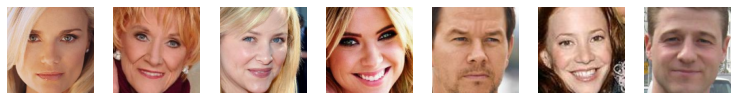

Anime Version


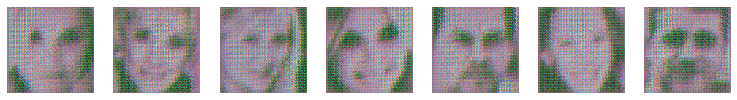

Epoch:1, Step:0, D-Loss:0.264, D-Acc:73.698, G-Loss:9.402
Epoch:1, Step:100, D-Loss:0.072, D-Acc:95.182, G-Loss:8.236
Epoch:1, Step:200, D-Loss:0.093, D-Acc:90.755, G-Loss:10.449
Epoch:1, Step:300, D-Loss:0.095, D-Acc:88.802, G-Loss:9.663
Epoch:1, Step:400, D-Loss:0.081, D-Acc:91.667, G-Loss:10.846
Epoch:1, Step:500, D-Loss:0.028, D-Acc:99.740, G-Loss:10.066
Epoch:1, Step:600, D-Loss:0.071, D-Acc:94.661, G-Loss:9.146
Epoch:1, Step:700, D-Loss:0.043, D-Acc:95.833, G-Loss:10.033
Epoch:1, Step:800, D-Loss:0.044, D-Acc:98.307, G-Loss:8.607
Epoch:1, Step:900, D-Loss:0.021, D-Acc:100.000, G-Loss:11.006
Human Face Images


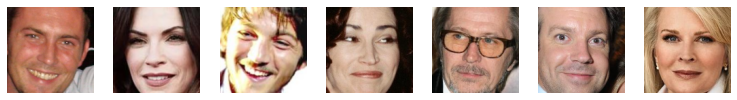

Anime Version


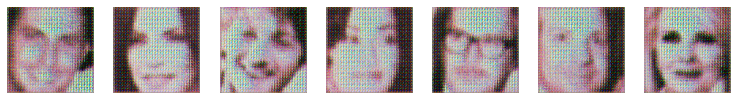

Epoch:2, Step:0, D-Loss:0.071, D-Acc:91.016, G-Loss:11.124


In [ ]:
epochs = 500
batch_size = 4
steps = 1000

for i in range(0, epochs):
    if i%1 == 0:
        show_generator_results(generator_network)
    for j in range(steps):  
        human_faces, anime_faces, smooth_anime_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        fake_anime_faces = generator_network(human_faces)
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(anime_faces, real_patch)
        loss_d_smooth = discriminator_network.train_on_batch(smooth_anime_faces, fake_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_anime_faces, fake_patch)
        
        loss_d = np.add(loss_d_real, np.add(loss_d_smooth, loss_d_fake))/3.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = cartoon_gan.train_on_batch(human_faces,[real_patch, human_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            